In [1]:
%matplotlib notebook
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import time, requests, json
from decouple import config
import pandas as pd
import numpy as np
import bitmex
import enum

## Order Status Enum

In [2]:
# Using enum class create enumerations
class OrderStatus(enum.Enum):
    NO_ORDER = 1
    LONG = 2
    SHORT = 3
    SQUARE_OFF = 4
    NEXT_ORDER = 5

## Initialize Bitmex Client

A Good Resource to start using bitmex API
https://medium.com/coinmonks/a-bitmex-python-tutorial-5f3cdf2491a7

Bitmex Costs
https://hackernoon.com/a-quick-starter-guide-to-using-leveraged-trading-at-bitmex-5383de4cb320

In [3]:
bitmex_api_key = config('BITMEX_API_KEY')  # Enter your own API-key here
bitmex_api_secret = config('BITMEX_SECRET_KEY')  # Enter your own API-secret here
client = bitmex.bitmex(test = False, api_key=bitmex_api_key, api_secret=bitmex_api_secret) 

c:\python37\lib\site-packages\swagger_spec_validator\validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


## Variable ---

In [4]:
symbol1 = 'XBTUSD'
symbol2 = 'BCHUSD'

### CSV Paths for Data
symbol1Path = './data/'+symbol1+'.csv'
symbol2Path = './data/'+symbol2+'.csv'

symbolcomposite = '.BBCHXBT'

data_count = 20000
bitmex_max_count = 1000
bin_size = '5m'

current_balance = starting_capital = 10000
algo_stop_balance = 0.1 * starting_capital

rolling_window = 150
sell_periods = 1

z_score_buy_threshold = -1
z_score_short_threshold = 1

transaction_fee = 0

leverage = 20

## Past Data Initializations

Read about https://www.bitmex.com/app/index/.BBCHXBT

In [5]:
def getHistoricalData(symbol,data_count):
    
    i_lim = np.ceil(data_count/bitmex_max_count)
    print("Getting Historical Data For " + symbol)
    for i in range(int(i_lim)-1,-1,-1):
        data_start_index = bitmex_max_count*i

#         print("Getting Data From Index " + str(data_start_index))

        past_data_list = reversed(
        client.Trade.Trade_getBucketed(
            binSize=bin_size,start=data_start_index ,count=bitmex_max_count, symbol=symbol, reverse=True
        ).result()[0])

        if(i == i_lim -1):
            past_dataframe_symbol = pd.DataFrame.from_records(past_data_list)
        else:
            past_dataframe_symbol = past_dataframe_symbol.append(
                pd.DataFrame.from_records(past_data_list),ignore_index=True)
        
    return past_dataframe_symbol

past_dataframe_symbol1 = pd.read_csv(symbol1Path)
past_dataframe_symbol2 = pd.read_csv(symbol2Path)
past_dataframe_symbolcomposite = past_dataframe_symbol1
# past_dataframe_symbolcomposite =getHistoricalData(symbolcomposite,data_count)

past_dataframe_symbol2.tail(1)

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
17999,2021-01-02 09:50:00+00:00,BCHUSD,343.05,343.45,343.2,343.35,23,1540,343.4,13.0,52882070,45.901347,15762.064484


## Constructing a main dataframe

In [6]:
ticker_main = [past_dataframe_symbol1.close,past_dataframe_symbol2.close,
               past_dataframe_symbol2.close/past_dataframe_symbol1.close]
headers = [symbol1,symbol2,symbolcomposite]
ticker_main_df = pd.concat(ticker_main, axis=1, keys=headers)
ticker_main_df

,XBTUSD,BCHUSD,.BBCHXBT
0,13845.0,263.00,0.018996
1,13845.0,263.00,0.018996
2,13833.0,263.00,0.019013
3,13833.0,263.00,0.019013
4,13832.5,263.10,0.019020
...,...,...,...
17995,29778.5,342.15,0.011490
17996,29775.0,342.00,0.011486
17997,29806.5,342.85,0.011503
17998,29847.5,343.05,0.011493


## Plotting the Symbols

<IPython.core.display.Javascript object>


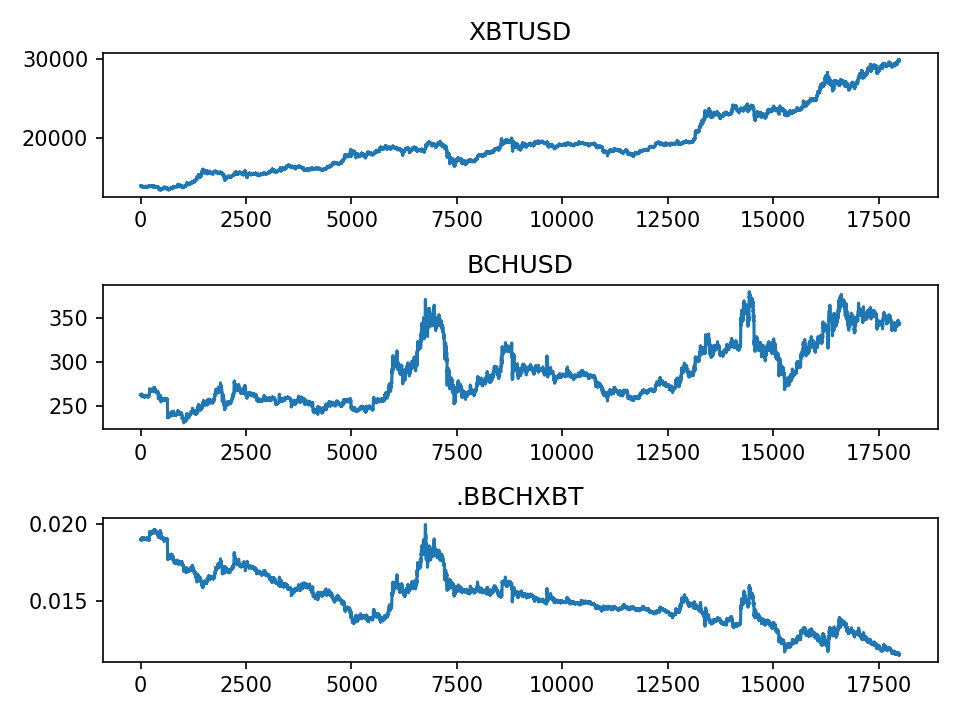

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1)

plt.subplot(3,1,1)
plt.plot(ticker_main_df[symbol1])
plt.title(symbol1)

plt.subplot(3,1,2)
plt.plot(ticker_main_df[symbol2])
plt.title(symbol2)

plt.subplot(3,1,3)
plt.plot(ticker_main_df[symbolcomposite])
plt.title(symbolcomposite)

fig.tight_layout()
plt.show()

## Regression Model for Hedge Ratio Calculation

In [8]:
ticker_main_df[symbol1 + '_log'] = np.log(ticker_main_df[symbol1])
ticker_main_df[symbol2 + '_log'] = np.log(ticker_main_df[symbol2])

regression_model = RollingOLS(ticker_main_df[symbol1 + '_log'], ticker_main_df[symbol2 + '_log'],rolling_window)
rolling_res = regression_model.fit()

ticker_main_df['Hedge_Ratio'] = rolling_res.params

ticker_main_df['Distance'] = ticker_main_df[symbol1 + '_log'] 
- (ticker_main_df['Hedge_Ratio'] * ticker_main_df[symbol2 + '_log'])

ticker_main_df['Mean_Dist'] = ticker_main_df['Distance'].rolling(rolling_window).mean()
ticker_main_df['Std_Dist'] = ticker_main_df['Distance'].rolling(rolling_window).std()

ticker_main_df['Z_Score'] = (ticker_main_df['Distance'] - ticker_main_df['Mean_Dist'])/(ticker_main_df['Std_Dist'])

In [9]:
ticker_main_df

,XBTUSD,BCHUSD,.BBCHXBT,XBTUSD_log,BCHUSD_log,Hedge_Ratio,Distance,Mean_Dist,Std_Dist,Z_Score
0,13845.0,263.00,0.018996,9.535679,5.572154,NaN,9.535679,NaN,NaN,NaN
1,13845.0,263.00,0.018996,9.535679,5.572154,NaN,9.535679,NaN,NaN,NaN
2,13833.0,263.00,0.019013,9.534812,5.572154,NaN,9.534812,NaN,NaN,NaN
3,13833.0,263.00,0.019013,9.534812,5.572154,NaN,9.534812,NaN,NaN,NaN
4,13832.5,263.10,0.019020,9.534776,5.572534,NaN,9.534776,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
17995,29778.5,342.15,0.011490,10.301542,5.835249,1.763991,10.301542,10.292191,0.007506,1.245899
17996,29775.0,342.00,0.011486,10.301424,5.834811,1.764002,10.301424,10.292302,0.007518,1.213414
17997,29806.5,342.85,0.011503,10.302482,5.837293,1.764009,10.302482,10.292416,0.007542,1.334645
17998,29847.5,343.05,0.011493,10.303856,5.837876,1.764019,10.303856,10.292543,0.007573,1.493869


<IPython.core.display.Javascript object>


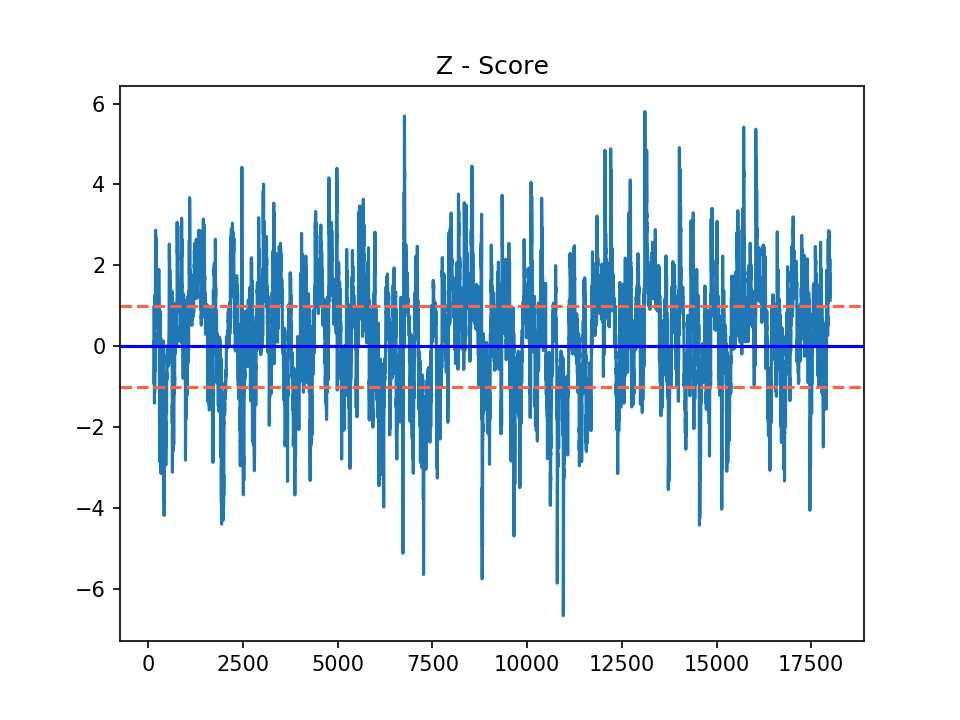

In [10]:
fig = plt.figure()
plt.plot(ticker_main_df['Z_Score'])
plt.axhline(y=0,color='b')
plt.axhline(y=z_score_buy_threshold,color='tomato',linestyle='--')
plt.axhline(y=z_score_short_threshold,color='tomato',linestyle='--')
plt.title("Z - Score")
plt.show()

In [18]:
current_balance = starting_capital
balance_list = []

## -------------------------------------------------------------------------------------------------------
order_status = OrderStatus.NO_ORDER
trade_count = 0

price_symbol1 = 0
price_symbol2 = 0

squareOff_price_symbol1 = 0
squareOff_price_symbol2 = 0

square_off_index = 0

order_id_price_symbol1 =0
order_id_price_symbol2 =0

order_details_cols = ['count',
'order_type',
'balance_prior',
'balance_post',
'order_id_price_symbol1',
'price_symbol1',
'balance_alloc_symbol',
'quantity_symbol1',
'squareOff_price_symbol1',
'squareOff_bal_symbol1',
'order_id_price_symbol2',
'price_symbol2',
'balance_alloc_symbol2',
'quantity_symbol2',
'squareOff_price_symbol2',
'squareOff_bal_symbol2']
order_details = pd.DataFrame(data=[],columns=order_details_cols)
order_details

,count,order_type,balance_prior,balance_post,order_id_price_symbol1,price_symbol1,balance_alloc_symbol,quantity_symbol1,squareOff_price_symbol1,squareOff_bal_symbol1,order_id_price_symbol2,price_symbol2,balance_alloc_symbol2,quantity_symbol2,squareOff_price_symbol2,squareOff_bal_symbol2


In [19]:
for index,row in ticker_main_df.iterrows():
    #print(index)
    ## Price of 1st Asset
    current_price_symbol1 = row[symbol1]
    
    ## Price of 2nd Asset
    current_price_symbol2 = row[symbol2]
    
    ## Z Score at the moment
    z_score = row["Z_Score"]
    
    ## For a Valid Portfolio Balance
    if current_balance > algo_stop_balance:
        if(order_status == OrderStatus.NO_ORDER and (z_score <= z_score_buy_threshold
                                                    or z_score >= z_score_short_threshold)):
            
            order_status = OrderStatus.NEXT_ORDER
            
            order_id_price_symbol1 = current_price_symbol1
            order_id_price_symbol2 = current_price_symbol2
        
        ## If there is no existing order in place, and Z-Score is below Buy Threshold!
        elif(order_status == OrderStatus.NEXT_ORDER and z_score <= z_score_buy_threshold):
            ## Long Order Initialized
            #print('Long Order Initialized!')
            order_status = OrderStatus.LONG
            
            ## Increment Trade Count 
            trade_count = trade_count + 1
            
            ## Set Square off Condition
            square_off_index = index + sell_periods
            
            ## Long Symbol 1 and Short Symbol 2
            price_symbol1 = current_price_symbol1
            price_symbol2 = current_price_symbol2
            
            
        elif(order_status == OrderStatus.NEXT_ORDER and z_score >= z_score_short_threshold):
            ## Short Order Initialized
            #print('Short Order Initialized!')
            order_status = OrderStatus.SHORT
            
            ## Increment Trade Count 
            trade_count = trade_count + 1
            
            ## Set Square off Condition
            square_off_index = index + sell_periods
            
            ## Short Symbol 1 and Long Symbol 2
            price_symbol1 = current_price_symbol1
            price_symbol2 = current_price_symbol2
        
        
        if(order_status != OrderStatus.NO_ORDER):
            
            ## Square off
            if(index == square_off_index):
                
                ## Update Square off prices
                squareOff_price_symbol1 = current_price_symbol1
                squareOff_price_symbol2 = current_price_symbol2
                
                ## Balance Allocation for Positions (inclusive of leverage)
                balance_alloc_symbol1 = 0.5  * leverage * current_balance
                balance_alloc_symbol2 = 0.5  * leverage * current_balance
                
                
                ##Long Square Off
                if(order_status == OrderStatus.LONG):
                    ## Buy Quantity (inclusive of Transaction Fee Deductions)
                    quantity_symbol1 = ((1 - transaction_fee) 
                                        * (balance_alloc_symbol1/price_symbol1))
                    ## Since Symbol2 is Shorted its Buy quantity is calcualted based on the squareoff price
                    quantity_symbol2 = ((1 - transaction_fee) 
                                        * (balance_alloc_symbol2/squareOff_price_symbol2))
                    
                    ## Balance after Square Off i.e Selling the bought quantity
                    squareOff_bal_symbol1 = ((1 - transaction_fee) 
                                             * (squareOff_price_symbol1 * quantity_symbol1))/leverage

                    squareOff_bal_symbol2 = ((1 - transaction_fee) 
                                             * (price_symbol2 * quantity_symbol2))/leverage
                    
                ##Short Square Off
                if(order_status == OrderStatus.SHORT):
                    ## Buy Quantity (inclusive of Transaction Fee Deductions)
                    ## Since Symbol2 is Shorted its Buy quantity is calcualted based on the squareoff price
                    quantity_symbol1= ((1 - transaction_fee) 
                                        * (balance_alloc_symbol1/squareOff_price_symbol1))
                    
                    quantity_symbol2 = ((1 - transaction_fee) 
                                        * (balance_alloc_symbol2/price_symbol2))
                    
                    
                    ## Balance after Square Off i.e Selling the bought quantity
                    squareOff_bal_symbol1 = ((1 - transaction_fee) 
                                             * (price_symbol1 * quantity_symbol1))/leverage
                    
                    squareOff_bal_symbol2 = ((1 - transaction_fee) 
                                             * (squareOff_price_symbol2 * quantity_symbol2))/leverage
                
                #print('Order Squares Off!')
                resultant_balance = squareOff_bal_symbol1 + squareOff_bal_symbol2
                
                order_details = order_details.append(pd.DataFrame(data=[[
                    trade_count,
                    order_status,
                    current_balance,
                    resultant_balance,
                    order_id_price_symbol1,
                    price_symbol1,
                    balance_alloc_symbol1,
                    quantity_symbol1,
                    squareOff_price_symbol1,
                    squareOff_bal_symbol1,
                    order_id_price_symbol2,
                    price_symbol2,
                    balance_alloc_symbol2,
                    quantity_symbol2,
                    squareOff_price_symbol2,
                    squareOff_bal_symbol2,
                ]],columns=order_details_cols))
                
                current_balance = resultant_balance
                order_status = OrderStatus.NO_ORDER
                
        balance_list.append(current_balance)
                

print(trade_count)
print(current_balance)
order_details

3073
9564.437544094937


,count,order_type,balance_prior,balance_post,order_id_price_symbol1,price_symbol1,balance_alloc_symbol,quantity_symbol1,squareOff_price_symbol1,squareOff_bal_symbol1,order_id_price_symbol2,price_symbol2,balance_alloc_symbol2,quantity_symbol2,squareOff_price_symbol2,squareOff_bal_symbol2
0,1,OrderStatus.LONG,10000,9998.355564,13677.0,13682.5,100000.000000,7.308606,13678.0,4998.355564,261.00,260.65,100000.000000,383.656244,260.65,5000.000000
0,2,OrderStatus.SHORT,9998.36,9999.982700,13685.5,13769.0,99983.555637,7.269417,13754.0,5004.629844,260.70,261.40,99983.555637,382.492562,261.20,4995.352856
0,3,OrderStatus.SHORT,9999.98,10000.795944,13770.5,13767.5,99999.827005,7.267429,13760.0,5002.716636,261.50,261.50,99999.827005,382.408516,261.40,4998.079308
0,4,OrderStatus.SHORT,10000.8,10008.796872,13773.0,13771.5,100007.959439,7.273571,13749.5,5008.398900,261.25,261.20,100007.959439,382.878865,261.20,5000.397972
0,5,OrderStatus.SHORT,10008.8,10014.106490,13778.5,13808.5,100087.968716,7.254591,13796.5,5008.751191,261.40,261.50,100087.968716,382.745578,261.55,5005.355300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3068,OrderStatus.SHORT,9553.63,9555.458730,29828.0,29849.5,95536.342134,3.199958,29855.5,4775.857119,342.80,343.10,95536.342134,278.450429,343.30,4779.601611
0,3069,OrderStatus.SHORT,9555.46,9554.979600,29867.0,29912.0,95554.587304,3.194203,29915.0,4777.250235,343.25,343.05,95554.587304,278.544199,343.05,4777.729365
0,3070,OrderStatus.SHORT,9554.98,9557.162044,29939.5,29877.5,95549.795999,3.196714,29890.0,4775.491853,342.75,342.85,95549.795999,278.692711,343.15,4781.670191
0,3071,OrderStatus.SHORT,9557.16,9557.610716,29829.5,29895.0,95571.620440,3.202802,29840.0,4787.388728,342.35,343.00,95571.620440,278.634462,342.40,4770.221988


In [13]:
def oldCode():
    for index,row in ticker_main_df.iterrows():
        current_price = row[symbolcomposite]
        z_score = row["Z_Score"]

        if current_balance > 0.1 and counts < (index_length - sell_periods):

            if open_orders == 1 and counts == time_period:

                sell_price = current_price
                net_return = (sell_price / buy_price)
                net_change = (sell_price - buy_price) / buy_price
                fees = (1-transaction_fee) * net_return
                current_balance = current_balance * fees
                returns_list.append(net_change)
                open_orders = 0

            if open_orders == 2 and counts == time_period:

                sell_price = current_price
                net_return = (short_price / sell_price)
                net_change = (short_price - sell_price) / short_price
                fees = (1-transaction_fee) * net_return
                current_balance = current_balance * fees
                returns_list.append(net_change)
                open_orders = 0

            if open_orders == 0 and z_score <= z_score_buy_threshold:
                short_price = current_price
                open_orders = 2
                time_period = counts + sell_periods

            if open_orders == 0 and z_score >= z_score_short_threshold:
                buy_price = current_price
                open_orders = 1
                time_period = counts + sell_periods

            #print(counts, "Balance " + str(current_balance), "Buy Price " + str(buy_price),
            #    "Sell Price "+ str(sell_price), "Net Return " + str(net_return))

        balance_list.append(current_balance)
        counts = counts +1

<IPython.core.display.Javascript object>


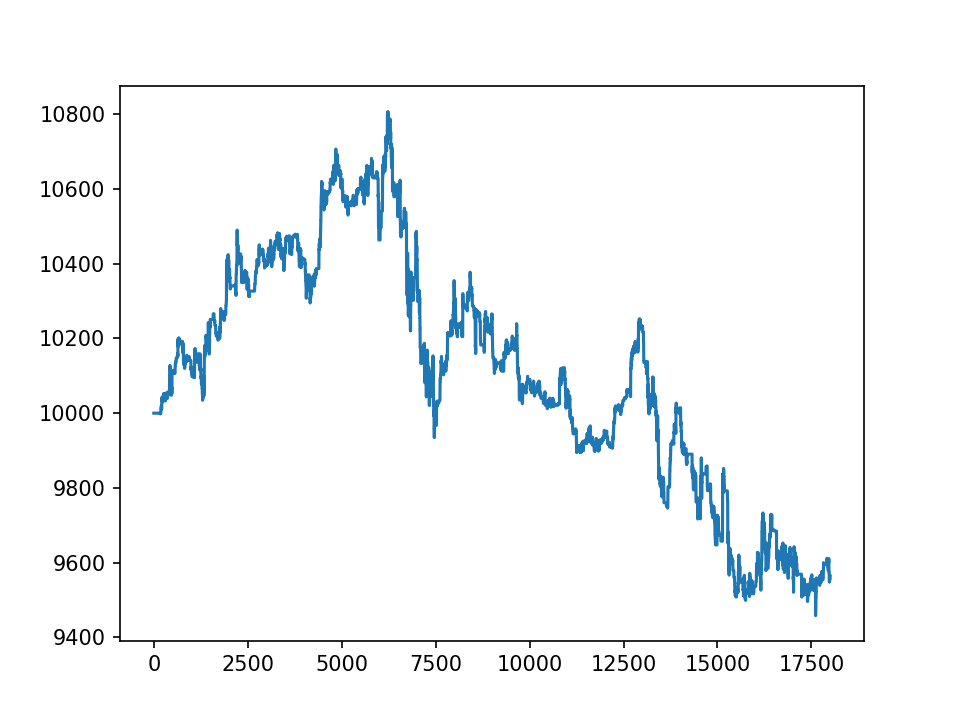

In [14]:
fig = plt.figure()
plt.plot(balance_list)
plt.show()

In [15]:
current_balance

9564.437544094937